# First Thing First: Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (confusion_matrix, classification_report,
                             precision_score, recall_score, f1_score,
                             roc_curve, roc_auc_score, precision_recall_curve,
                             RocCurveDisplay, PrecisionRecallDisplay)
import warnings
warnings.filterwarnings("ignore")
# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

Now we will load the dataset. The Breast Cancer Dataset is already avaliable in Sklearn so we can just import it easily.

We can check what we have in our dataset: how many patients, number of benigns and malignants.

In [ ]:
# Load the breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

# Create a DataFrame for better visualization
df = pd.DataFrame(X, columns=data.feature_names)
df['diagnosis'] = y
df['diagnosis_label'] = df['diagnosis'].map({0: 'Malignant', 1: 'Benign'})

print("Wisconsin Breast Cancer Dataset")
print("=" * 60)
print(f"✓ Total patients: {len(df)}")
print(f"✓ Features: {len(data.feature_names)}")
print(f"✓ Benign cases: {sum(y == 1)} ({sum(y == 1)/len(y)*100:.1f}%)")
print(f"✓ Malignant cases: {sum(y == 0)} ({sum(y == 0)/len(y)*100:.1f}%)")
print("\n Sample Data:")

# Sample rows with key features
key_features = ['mean radius', 'mean texture', 'mean smoothness', 'mean compactness', 'diagnosis_label']
display(df[key_features].head(10).style.set_properties(**{
    'background-color': 'lightblue',
    'color': 'black',
    'border-color': 'white'
}))

Wisconsin Breast Cancer Dataset
✓ Total patients: 569
✓ Features: 30
✓ Benign cases: 357 (62.7%)
✓ Malignant cases: 212 (37.3%)

 Sample Data:


,mean radius,mean texture,mean smoothness,mean compactness,diagnosis_label
0,17.990000,10.380000,0.118400,0.277600,Malignant
1,20.570000,17.770000,0.084740,0.078640,Malignant
2,19.690000,21.250000,0.109600,0.159900,Malignant
3,11.420000,20.380000,0.142500,0.283900,Malignant
4,20.290000,14.340000,0.100300,0.132800,Malignant
5,12.450000,15.700000,0.127800,0.170000,Malignant
6,18.250000,19.980000,0.094630,0.109000,Malignant
7,13.710000,20.830000,0.118900,0.164500,Malignant
8,13.000000,21.820000,0.127300,0.193200,Malignant
9,12.460000,24.040000,0.118600,0.239600,Malignant


It is always good idea to start with visualizing your data.

In our case, we can visualize how seperated these 2 classes based on important features like mean radius and mean texture.

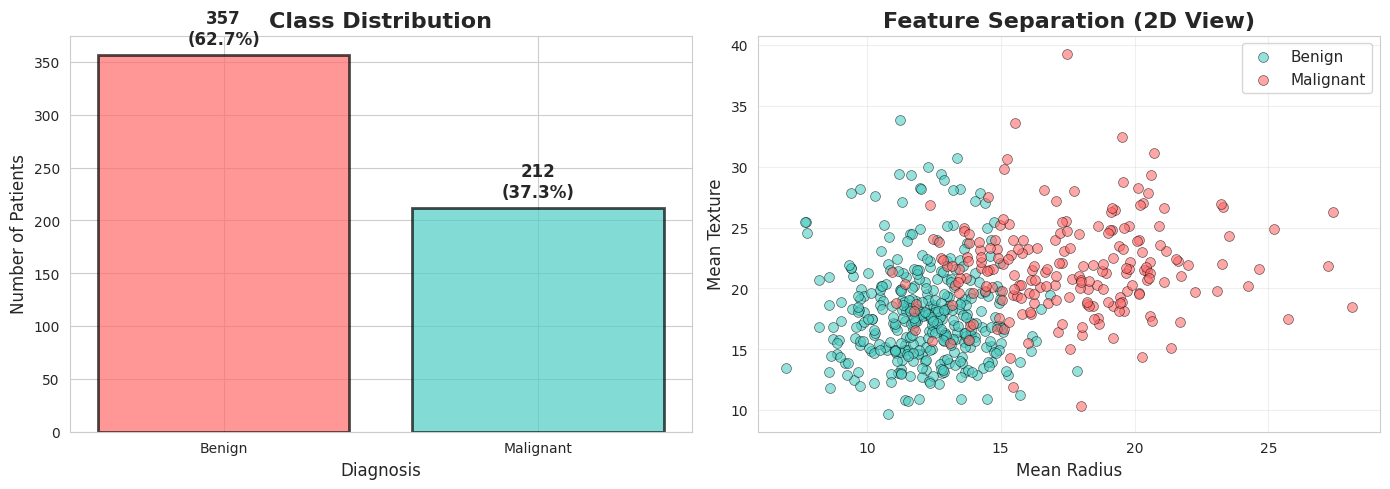


 Notice: The two classes show some separation, but overlap exists.
   This is why we need good models AND good evaluation!


In [ ]:
#Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Class distribution
colors = ['#FF6B6B', '#4ECDC4']
class_counts = df['diagnosis_label'].value_counts()
axes[0].bar(class_counts.index, class_counts.values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[0].set_title('Class Distribution', fontsize=16, fontweight='bold')
axes[0].set_ylabel('Number of Patients', fontsize=12)
axes[0].set_xlabel('Diagnosis', fontsize=12)

# Add value labels on bars
for i, (label, count) in enumerate(class_counts.items()):
    axes[0].text(i, count + 10, f'{count}\n({count/len(df)*100:.1f}%)',
                ha='center', fontsize=12, fontweight='bold')

# Scatter plot showing separation
axes[1].scatter(df[df['diagnosis'] == 1]['mean radius'],
               df[df['diagnosis'] == 1]['mean texture'],
               alpha=0.6, s=50, c='#4ECDC4', label='Benign', edgecolors='black', linewidth=0.5)
axes[1].scatter(df[df['diagnosis'] == 0]['mean radius'],
               df[df['diagnosis'] == 0]['mean texture'],
               alpha=0.6, s=50, c='#FF6B6B', label='Malignant', edgecolors='black', linewidth=0.5)
axes[1].set_xlabel('Mean Radius', fontsize=12)
axes[1].set_ylabel('Mean Texture', fontsize=12)
axes[1].set_title('Feature Separation (2D View)', fontsize=16, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Notice: The two classes show some separation, but overlap exists.")
print("   This is why we need good models AND good evaluation!")

Also numerically we can look at important feature statistics

In [ ]:
# Show feature statistics
print("\n Key Feature Statistics")
print("=" * 80)

# Select a few important features
important_features = ['mean radius', 'mean texture', 'mean smoothness', 'mean compactness']

stats_df = df.groupby('diagnosis_label')[important_features].agg(['mean', 'std']).round(2)
display(stats_df)

print("\n Observation: Malignant tumors tend to have different characteristics!")


 Key Feature Statistics


mean radius       mean texture       mean smoothness        \
                       mean   std         mean   std            mean   std   
diagnosis_label                                                              
Benign                12.15  1.78        17.91  4.00            0.09  0.01   
Malignant             17.46  3.20        21.60  3.78            0.10  0.01   

                mean compactness        
                            mean   std  
diagnosis_label                         
Benign                      0.08  0.03  
Malignant                   0.15  0.05


 Observation: Malignant tumors tend to have different characteristics!


Lets start implementing ML model for classifiying diffrent tumors.

 For this example we can use Logistic Regression Model.

 You remember from previous class that we should do train test split and train our model on training samples and then evaluate it on never seen test samples.

The train_test_split function randomly divides the data into train and test chunks. That means, if we change the random_state value we might end up with very different train and test chunks.



In [ ]:
# Demonstrate the "Lucky Split" problem
print(" THE ACCURACY TRAP: Single Train-Test Split")
print("=" * 80)
print("\nLet's train the SAME model with different random splits...\n")

# We'll use Logistic Regression for this demo
model = LogisticRegression()

# Try different random states
random_states = [42, 17, 99, 7, 123, 456, 789, 2024]
accuracies = []

print(f"{'Random State':<15} {'Accuracy':<15} {'Difference from mean'}")
print("-" * 60)

for rs in random_states:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=rs)
    model.fit(X_train, y_train)
    acc = model.score(X_test, y_test)
    accuracies.append(acc)

mean_acc = np.mean(accuracies)

for rs, acc in zip(random_states, accuracies):
    diff = acc - mean_acc
    print(f"{rs:<15} {acc:<15.3f} {diff:+.3f}")

print("-" * 60)
print(f"{'Mean':<15} {mean_acc:<15.3f}")
print(f"{'Std Dev':<15} {np.std(accuracies):<15.3f}")
print(f"{'Range':<15} {max(accuracies) - min(accuracies):<15.3f}")

print("\n PROBLEM: Which accuracy do you report to the hospital?")
print("    The highest one? The lowest? You just got lucky/unlucky!")

 THE ACCURACY TRAP: Single Train-Test Split

Let's train the SAME model with different random splits...

Random State    Accuracy        Difference from mean
------------------------------------------------------------
42              0.965           +0.010
17              0.930           -0.024
99              0.958           +0.003
7               0.944           -0.010
123             0.986           +0.031
456             0.972           +0.017
789             0.944           -0.010
2024            0.937           -0.017
------------------------------------------------------------
Mean            0.955          
Std Dev         0.018          
Range           0.056          

 PROBLEM: Which accuracy do you report to the hospital?
    The highest one? The lowest? You just got lucky/unlucky!


You can visualize the accuracy of different random seeds.

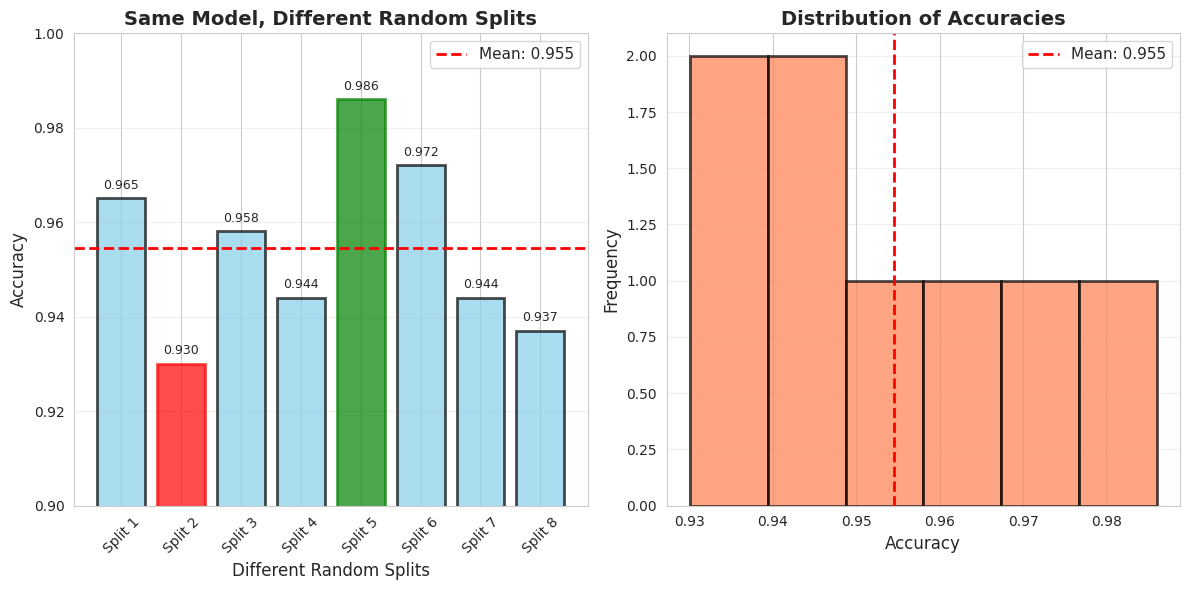


 Key Insight: Can't trust a single split! We need Cross-Validation!


In [ ]:
# Visualize the variance in accuracy
plt.figure(figsize=(12, 6))

# Plot accuracies with different random states
plt.subplot(1, 2, 1)
bars = plt.bar(range(len(random_states)), accuracies, color='skyblue', alpha=0.7, edgecolor='black', linewidth=2)
plt.axhline(y=mean_acc, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_acc:.3f}')
plt.xlabel('Different Random Splits', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Same Model, Different Random Splits', fontsize=14, fontweight='bold')
plt.xticks(range(len(random_states)), [f'Split {i+1}' for i in range(len(random_states))], rotation=45)
plt.legend(fontsize=11)
plt.ylim([0.9, 1.0])
plt.grid(axis='y', alpha=0.3)

# Highlight best and worst
best_idx = np.argmax(accuracies)
worst_idx = np.argmin(accuracies)
bars[best_idx].set_color('green')
bars[worst_idx].set_color('red')

# Add text annotations
for i, (rs, acc) in enumerate(zip(random_states, accuracies)):
    plt.text(i, acc + 0.002, f'{acc:.3f}', ha='center', fontsize=9)

# Histogram of accuracies
plt.subplot(1, 2, 2)
plt.hist(accuracies, bins=6, color='coral', alpha=0.7, edgecolor='black', linewidth=2)
plt.axvline(x=mean_acc, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_acc:.3f}')
plt.xlabel('Accuracy', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Accuracies', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n Key Insight: Can't trust a single split! We need Cross-Validation!")

Interview moment




For proper implementeation and evaluation you dont rely on just one model but you can implement different ML models, and while evaluating their performance you use cross-validation.

In [ ]:
# Proper evaluation with Cross-Validation
print("✅ THE SOLUTION: Cross-Validation")
print("=" * 80)
print("\nLet's evaluate models PROPERLY using 10-fold Cross-Validation\n")

# Define models
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(probability=True, random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier()
}

# Perform cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
results = {}

print(f"{'Model':<25} {'Mean Accuracy':<15} {'Std Dev':<15} {'Min':<10} {'Max':<10}")
print("-" * 85)

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    results[name] = scores

    print(f"{name:<25} {scores.mean():<15.3f} {scores.std():<15.3f} {scores.min():<10.3f} {scores.max():<10.3f}")

print("\n Now we have RELIABLE estimates with confidence intervals!")

✅ THE SOLUTION: Cross-Validation

Let's evaluate models PROPERLY using 10-fold Cross-Validation

Model                     Mean Accuracy   Std Dev         Min        Max       
-------------------------------------------------------------------------------------
Logistic Regression       0.940           0.030           0.877      1.000     
Decision Tree             0.926           0.023           0.895      0.965     
Random Forest             0.956           0.024           0.912      1.000     
SVM                       0.916           0.037           0.842      0.982     
K-Nearest Neighbors       0.935           0.029           0.860      0.965     

 Now we have RELIABLE estimates with confidence intervals!


Again visualization is everything, so you visualize your results to communicate better with the board.


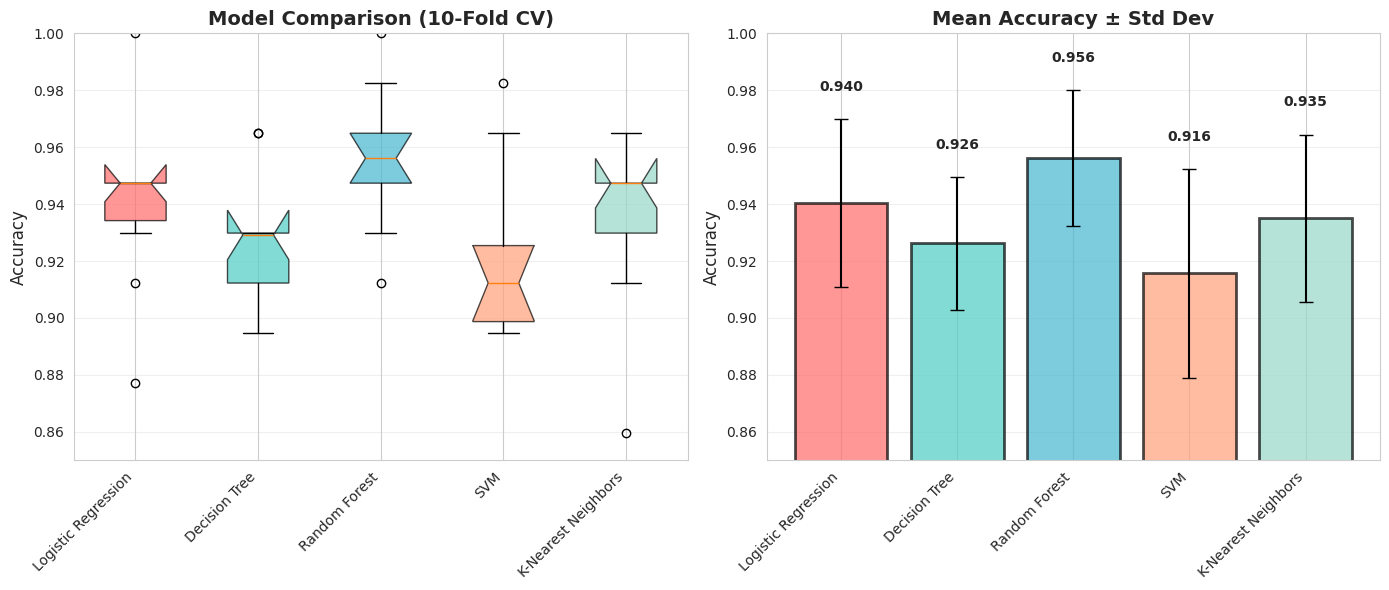


 Key Observations:
   1. Random Forest has highest mean accuracy
   3. Look at the variance (error bars) - which model is most STABLE?


In [ ]:
# Visualize model comparison with variance
plt.figure(figsize=(14, 6))

# Box plot
plt.subplot(1, 2, 1)
bp = plt.boxplot([results[name] for name in models.keys()],
                  labels=models.keys(),
                  patch_artist=True,
                  notch=True)

# Color the boxes
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

plt.ylabel('Accuracy', fontsize=12)
plt.title('Model Comparison (10-Fold CV)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.ylim([0.85, 1.0])

# Bar plot with error bars
plt.subplot(1, 2, 2)
names = list(models.keys())
means = [results[name].mean() for name in names]
stds = [results[name].std() for name in names]

bars = plt.bar(range(len(names)), means, yerr=stds,
               capsize=5, alpha=0.7, color=colors, edgecolor='black', linewidth=2)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Mean Accuracy ± Std Dev', fontsize=14, fontweight='bold')
plt.xticks(range(len(names)), names, rotation=45, ha='right')
plt.ylim([0.85, 1.0])
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, (mean, std) in enumerate(zip(means, stds)):
    plt.text(i, mean + std + 0.01, f'{mean:.3f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n Key Observations:")
print("   1. Random Forest has highest mean accuracy")
print("   3. Look at the variance (error bars) - which model is most STABLE?")

It is great that you found the best model that gives you the HIGHEST ACCURACY, but is it enough metric to deploy in production?? Especially for the healthcare system?

We can visualize the confusion matrix to clearly see where each models fails.

 CONFUSION MATRIX DETECTIVE

Let's see what mistakes each model makes...



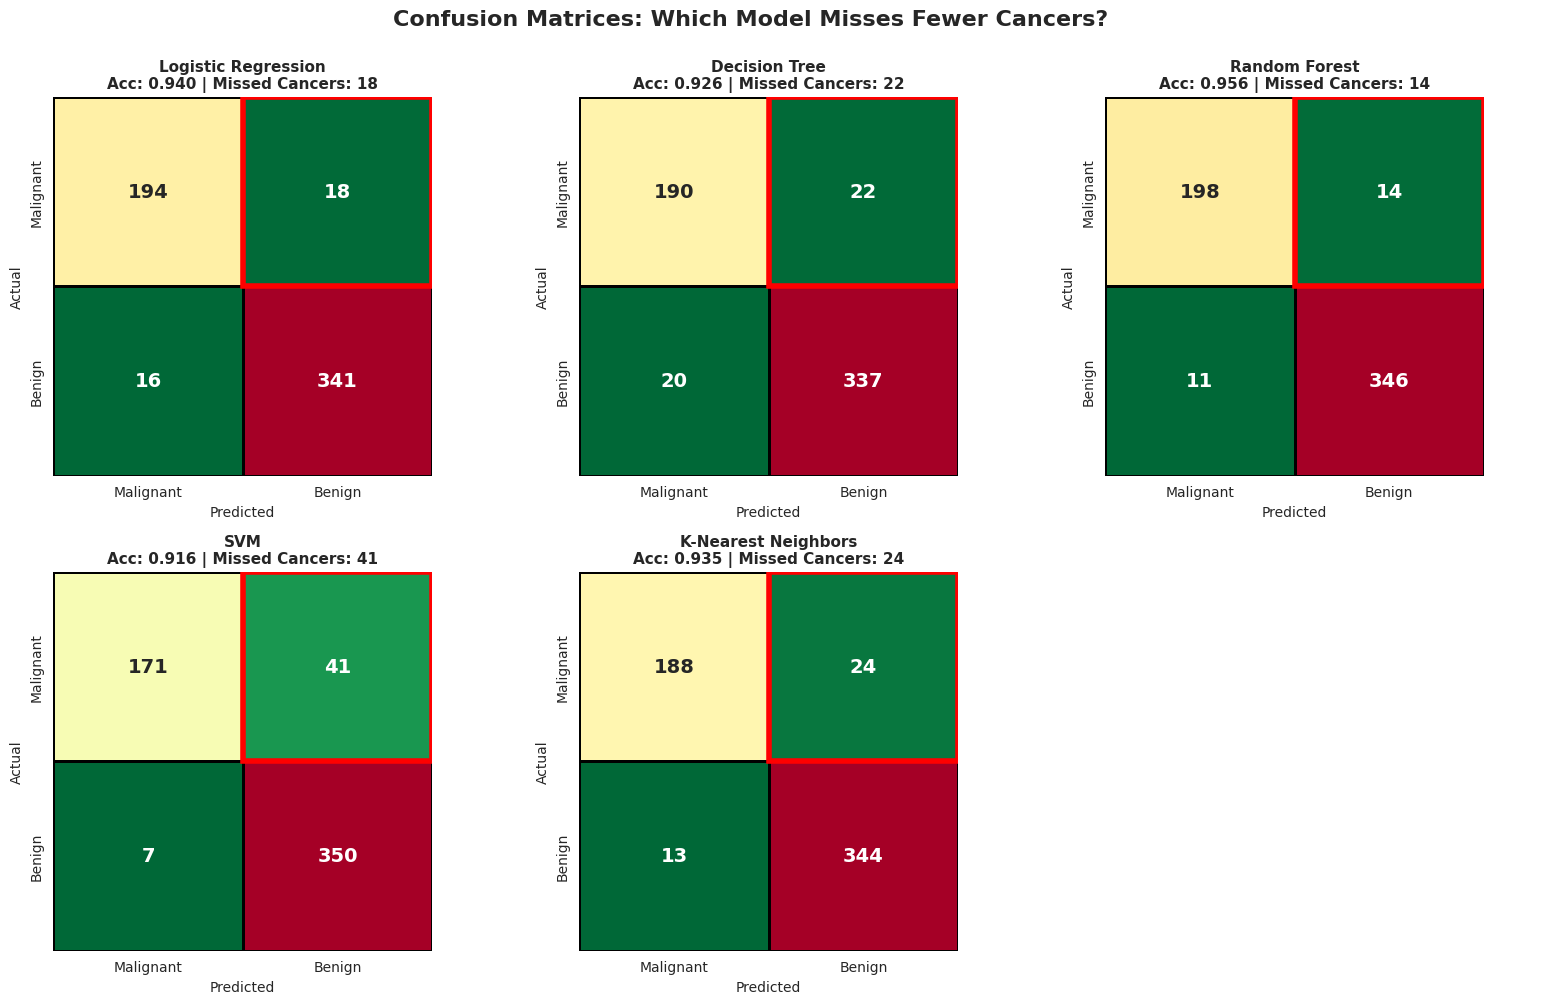

In [ ]:
# Detailed confusion matrix analysis
print(" CONFUSION MATRIX DETECTIVE")
print("=" * 80)
print("\nLet's see what mistakes each model makes...\n")

# Use cross_val_predict to get predictions for the entire dataset
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, (name, model) in enumerate(models.items()):
    # Get predictions using cross-validation
    y_pred = cross_val_predict(model, X, y, cv=cv)

    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    correct_cancer, missed_cancer, false_alarm, correct_benign = cm.ravel()
    # In standard ML terminology where we care about detecting disease:
    tp = correct_cancer  # True Positive (caught the cancer)
    fn = missed_cancer   # False Negative (missed the cancer)
    fp = false_alarm     # False Positive (false alarm)
    tn = correct_benign  # True Negative (correctly said healthy)

    # Calculate metrics
    #tn, fn, fp, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Note: In this dataset, 0=Malignant, 1=Benign
    # FN = missed cancer cases (predicted benign but actually malignant)
    # FP = false alarms (predicted malignant but actually benign)

    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='RdYlGn_r', ax=axes[idx],
                square=True, linewidths=2, linecolor='black', cbar=False,
                annot_kws={"size": 14, "weight": "bold"})

    axes[idx].set_title(f'{name}\nAcc: {accuracy:.3f} | Missed Cancers: {fn}',
                       fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Actual', fontsize=10)
    axes[idx].set_xlabel('Predicted', fontsize=10)
    axes[idx].set_xticklabels(['Malignant', 'Benign'])
    axes[idx].set_yticklabels(['Malignant', 'Benign'])

    # Highlight False Negatives
    axes[idx].add_patch(plt.Rectangle((1, 0), 1, 1, fill=False, edgecolor='red', lw=4))

# Hide the last subplot (we have 5 models, 6 subplots)
axes[5].axis('off')

plt.suptitle('Confusion Matrices: Which Model Misses Fewer Cancers?',
             fontsize=16, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

In [ ]:
# Detailed Metric Comparison
print("\n DETAILED METRICS COMPARISON")
print("=" * 100)
print(f"{'Model':<25} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Missed Cancers'}")
print("-" * 100)

for name, model in models.items():
    y_pred = cross_val_predict(model, X, y, cv=cv)

    # Calculate metrics FOR CANCER DETECTION (class 0)
    cm = confusion_matrix(y, y_pred)
    fn = cm[0, 1]  # Missed cancers (predicted benign but actually malignant)

    # Accuracy
    acc = np.mean(y_pred == y)

    # Use pos_label=0 to calculate metrics for CANCER (malignant) class
    prec = precision_score(y, y_pred, pos_label=0)
    rec = recall_score(y, y_pred, pos_label=0)
    f1 = f1_score(y, y_pred, pos_label=0)

    print(f"{name:<25} {acc:<12.3f} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f} {fn}")

print("\n These metrics are for CANCER DETECTION (class 0 = Malignant)!")
print("   • Precision: Of patients flagged as having cancer, what % actually have it?")
print("   • Recall: Of patients with cancer, what % did we successfully catch?")
print("   • HIGH RECALL is critical in cancer diagnosis - we can't afford to miss cases!")


 DETAILED METRICS COMPARISON
Model                     Accuracy     Precision    Recall       F1-Score     Missed Cancers
----------------------------------------------------------------------------------------------------
Logistic Regression       0.940        0.924        0.915        0.919        18
Decision Tree             0.926        0.905        0.896        0.900        22
Random Forest             0.956        0.947        0.934        0.941        14
SVM                       0.916        0.961        0.807        0.877        41
K-Nearest Neighbors       0.935        0.935        0.887        0.910        24

 These metrics are for CANCER DETECTION (class 0 = Malignant)!
   • Precision: Of patients flagged as having cancer, what % actually have it?
   • Recall: Of patients with cancer, what % did we successfully catch?
   • HIGH RECALL is critical in cancer diagnosis - we can't afford to miss cases!


When we have different metrics like precision and recall and struggle which model to choose, we can use ROC curves along with the accuracy.

ROC curves are everywhere in classification tasks because they’re intuitive and give a sense of how well your model can separate positive from negative classes across different thresholds.

In [ ]:
# Model Tournament - Detailed Comparison
print(" THE MODEL TOURNAMENT: Complete Analysis")
print("=" * 80)
print("\nLet's compare models on MULTIPLE dimensions, not just accuracy!\n")

# IMPORTANT: Check label encoding
print(" Label Encoding Check:")
print(f"   Malignant (Cancer) = 0")
print(f"   Benign (Healthy) = 1")
print(f"   We'll use probability of MALIGNANT (class 0) for ROC curves\n")

# Train all models and collect comprehensive metrics
tournament_results = {}

for name, model in models.items():
    print(f"Evaluating {name}...")

    # Get predictions and probabilities
    y_pred = cross_val_predict(model, X, y, cv=cv)
    y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')

    # CRITICAL FIX: Use probability of MALIGNANT (class 0), not benign
    # Since malignant = 0, we want y_proba[:, 0]
    y_scores = y_proba[:, 0]

    # Calculate all metrics
    cv_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')

    # Invert y for ROC calculation so malignant becomes 1
    y_inverted = 1 - y  # Now malignant=1, benign=0
    auc = roc_auc_score(y_inverted, y_scores)
    fpr, tpr, _ = roc_curve(y_inverted, y_scores)

    tournament_results[name] = {
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
        'y_scores': y_scores
    }

print("\n All models evaluated!\n")

 THE MODEL TOURNAMENT: Complete Analysis

Let's compare models on MULTIPLE dimensions, not just accuracy!

 Label Encoding Check:
   Malignant (Cancer) = 0
   Benign (Healthy) = 1
   We'll use probability of MALIGNANT (class 0) for ROC curves

Evaluating Logistic Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating SVM...
Evaluating K-Nearest Neighbors...

 All models evaluated!



In [ ]:
# Display results table
print(" MODEL COMPARISON TABLE")
print("=" * 80)
print(f"{'Model':<25} {'ROC AUC':<12} {'CV Accuracy':<18} {'Assessment'}")
print("-" * 80)

for name, results in tournament_results.items():
    assessment = ""
    if results['auc'] >= 0.99:
        assessment = "Excellent ⭐⭐⭐"
    elif results['auc'] >= 0.97:
        assessment = "Very Good ⭐⭐"
    elif results['auc'] >= 0.95:
        assessment = "Good ⭐"
    else:
        assessment = "Fair"

    print(f"{name:<25} {results['auc']:<12.3f} {results['cv_mean']:.3f} ± {results['cv_std']:.3f}    {assessment}")



 MODEL COMPARISON TABLE
Model                     ROC AUC      CV Accuracy        Assessment
--------------------------------------------------------------------------------
Logistic Regression       0.988        0.940 ± 0.030    Very Good ⭐⭐
Decision Tree             0.920        0.926 ± 0.023    Fair
Random Forest             0.989        0.956 ± 0.024    Very Good ⭐⭐
SVM                       0.972        0.916 ± 0.037    Very Good ⭐⭐
K-Nearest Neighbors       0.963        0.935 ± 0.029    Good ⭐


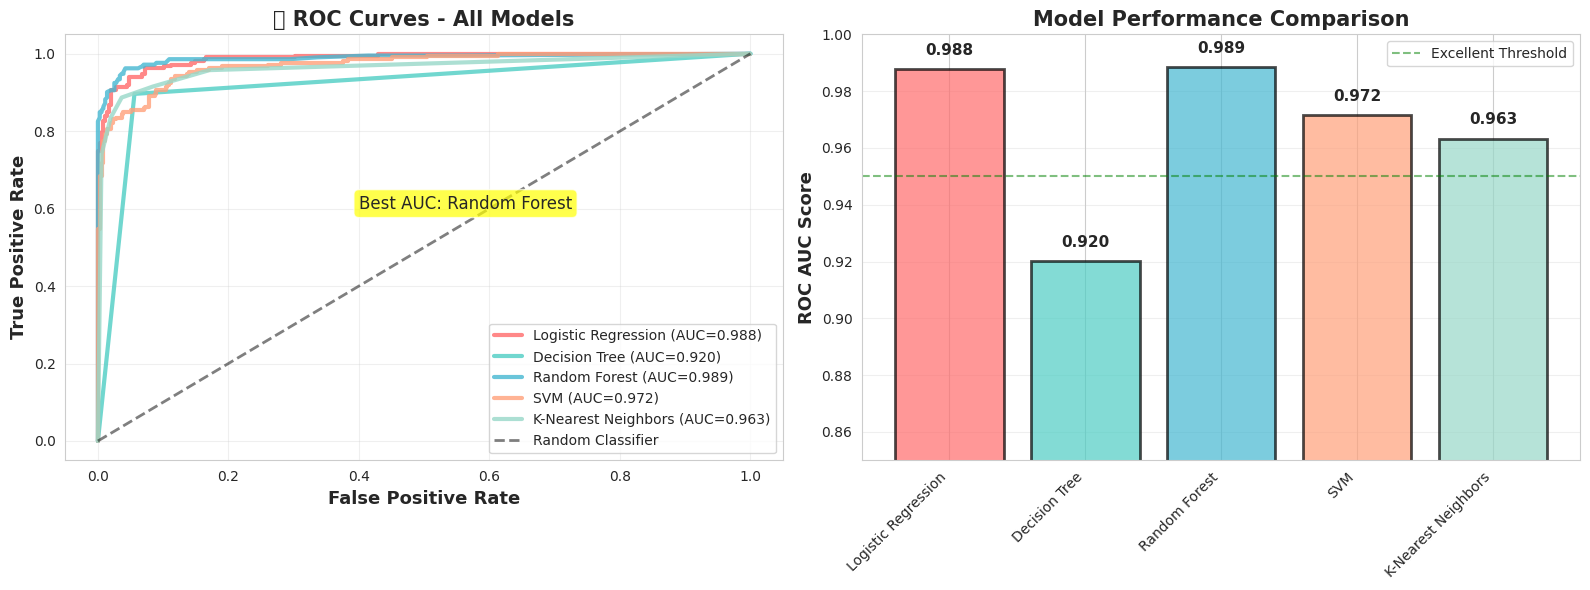

   • Best AUC: Random Forest (0.989)


In [ ]:
# Cell: Visualize Model Tournament - ROC Curves
plt.figure(figsize=(16, 6))

# Plot 1: ROC Curves Comparison
plt.subplot(1, 2, 1)

colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A', '#98D8C8']
for (name, results), color in zip(tournament_results.items(), colors):
    plt.plot(results['fpr'], results['tpr'],
             linewidth=3, label=f"{name} (AUC={results['auc']:.3f})",
             color=color, alpha=0.8)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, alpha=0.5, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=13, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=13, fontweight='bold')
plt.title('🏆 ROC Curves - All Models', fontsize=15, fontweight='bold')
plt.legend(fontsize=10, loc='lower right')
plt.grid(alpha=0.3)

# Add annotation for best model
best_model = max(tournament_results.items(), key=lambda x: x[1]['auc'])
plt.annotate(f'Best AUC: {best_model[0]}',
            xy=(0.4, 0.6), fontsize=12,
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Plot 2: AUC Comparison Bar Chart
plt.subplot(1, 2, 2)

models_list = list(tournament_results.keys())
aucs = [tournament_results[m]['auc'] for m in models_list]

x_pos = np.arange(len(models_list))
bars = plt.bar(x_pos, aucs, color=colors, alpha=0.7, edgecolor='black', linewidth=2)

# Add AUC values on bars
for i, auc in enumerate(aucs):
    plt.text(i, auc + 0.005, f'{auc:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.ylabel('ROC AUC Score', fontsize=13, fontweight='bold')
plt.title('Model Performance Comparison', fontsize=15, fontweight='bold')
plt.xticks(x_pos, models_list, rotation=45, ha='right')
plt.ylim([0.85, 1.0])
plt.axhline(y=0.95, color='green', linestyle='--', alpha=0.5, label='Excellent Threshold')
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"   • Best AUC: {best_model[0]} ({best_model[1]['auc']:.3f})")


When we are dealing with healthcare datasets we need to be careful with precision vs recall tradeoff as the both cases could bring different costs.

So it is critical to experiment with different threshold values.

The threshold value here defines the model's confidence probability.

In this setup we apply the threshold on benign class (threshold on P(benign)),so increasing the threshold makes the model more conservative about predicting benign, which increases malignant detection (recall) at the cost of more false alarms.

Setting the threshold to 0.3 means a sample is classified as benign if its predicted probability of being benign is at least 0.3; otherwise it is classified as malignant. Even if the model is less confident whether it is benign it will still classify it as benign.

In [ ]:
# Understanding decision thresholds
print(" THE THRESHOLD GAME")
print("=" * 80)
print("\nMost models return probabilities, not just yes/no predictions.")
print("We can adjust the threshold to change the tradeoff!\n")

# Train a model and get probability predictions
model = RandomForestClassifier()
y_proba = cross_val_predict(model, X, y, cv=cv, method='predict_proba')

# Get probabilities for the positive class (Benign = 1)
y_scores = y_proba[:, 1]

# Try different thresholds
thresholds_to_test = [0.3, 0.5, 0.7, 0.9]

print(f"{'Threshold':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'Missed Cancers':<15} {'False Alarms'}")
print("-" * 90)

for threshold in thresholds_to_test:
    # Make predictions with this threshold
    y_pred_threshold = (y_scores >= threshold).astype(int)

    # Calculate metrics
    cm = confusion_matrix(y, y_pred_threshold)
    tn, fn, fp, tp = cm.ravel()

    acc = (tp + tn) / (tp + tn + fp + fn)
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0

    print(f"{threshold:<12.1f} {acc:<12.3f} {prec:<12.3f} {rec:<12.3f} {fn:<15} {fp}")

print("\n Key Insight:")
print("   Lower threshold → Fewer false alarms (better precision), but miss some cancers")
print("   Higher threshold → Catch more cancers (better recall), but more false alarms")
print("\n❓ Where would YOU set the threshold?")



 THE THRESHOLD GAME

Most models return probabilities, not just yes/no predictions.
We can adjust the threshold to change the tradeoff!

Threshold    Accuracy     Precision    Recall       Missed Cancers  False Alarms
------------------------------------------------------------------------------------------
0.3          0.944        0.994        0.922        30              2
0.5          0.960        0.975        0.961        14              9
0.7          0.947        0.933        0.982        6               24
0.9          0.886        0.826        0.990        3               62

 Key Insight:
   Lower threshold → Fewer false alarms (better precision), but miss some cancers
   Higher threshold → Catch more cancers (better recall), but more false alarms

❓ Where would YOU set the threshold?


There are real costs we need to think about when actually deploying something.

For the example with cancer diagnosis, we will have different consequences and different costs for different metrics.

Let's assume that the cost of False Negative (Saying a patient that they dont have the cancer where they actually have) is 50,000 $ for the hospital. Because the patient might sue the hospital and treatment is delayed.

Let's assume that the cost of a False Positive (saying a patient has cancer when they don’t) is $5,000, because the hospital will do unnecessary tests and cause patient anxiety.


Based on these real costs we will need to do cost analysis and decide on the optimum threshold.

Health is the top priority, so basing such important decisions on cost alone doesn’t make sense—though there’s also a business side to it (for business people).


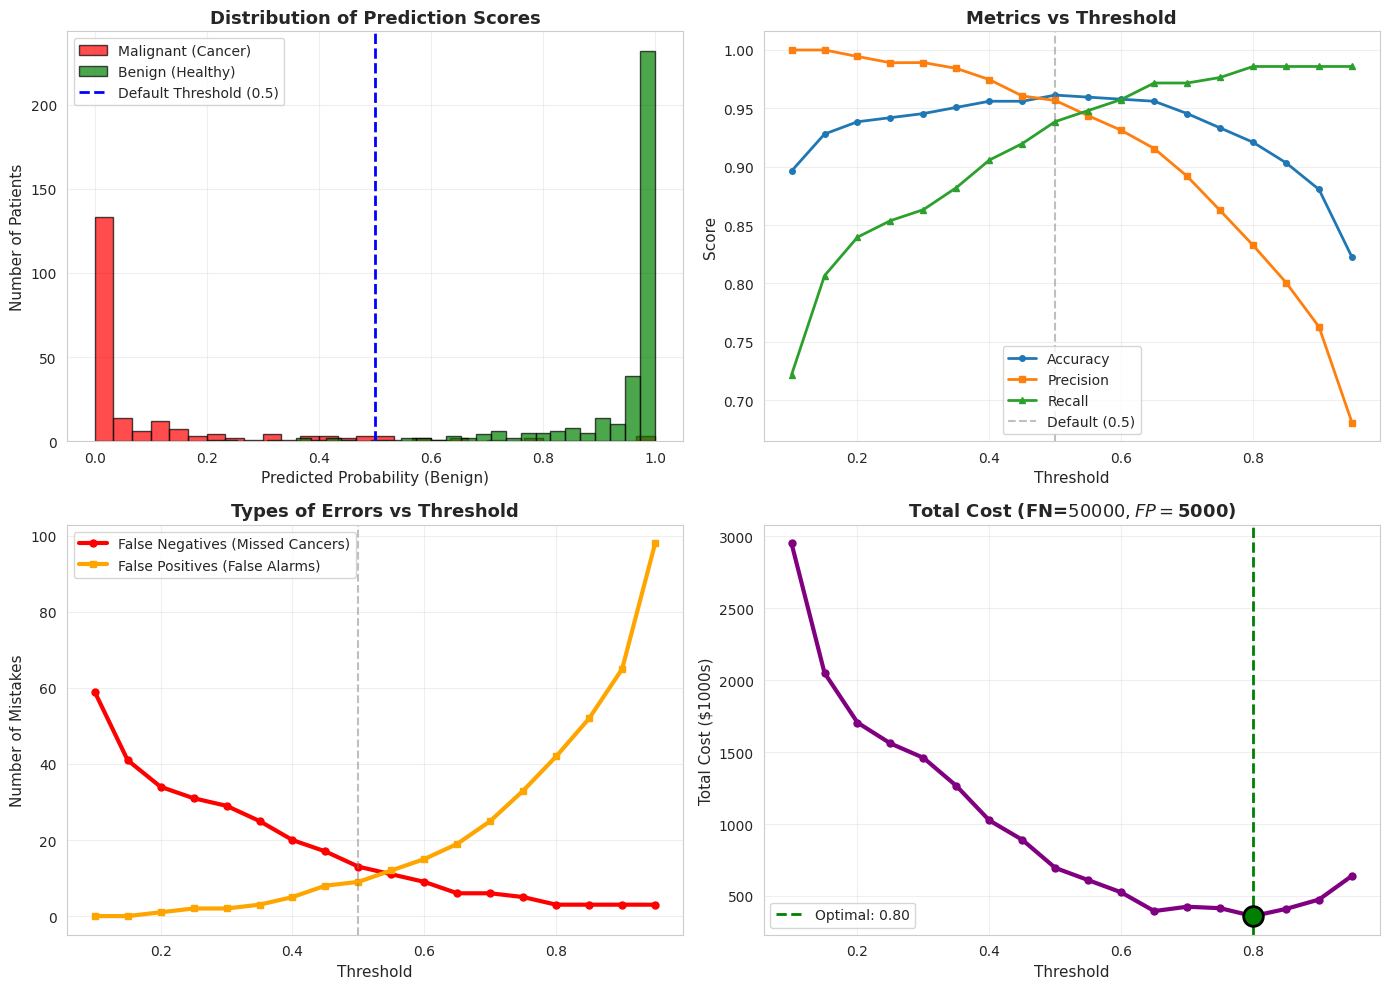


 Optimal threshold for cost minimization: 0.80
   Total cost at this threshold: $360.0K
   False Negatives: 3
   False Positives: 42


In [ ]:
# Visualize the threshold effect
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Score distribution
axes[0, 0].hist(y_scores[y == 0], bins=30, alpha=0.7, label='Malignant (Cancer)', color='red', edgecolor='black')
axes[0, 0].hist(y_scores[y == 1], bins=30, alpha=0.7, label='Benign (Healthy)', color='green', edgecolor='black')
axes[0, 0].axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Default Threshold (0.5)')
axes[0, 0].set_xlabel('Predicted Probability (Benign)', fontsize=11)
axes[0, 0].set_ylabel('Number of Patients', fontsize=11)
axes[0, 0].set_title('Distribution of Prediction Scores', fontsize=13, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Metrics vs Threshold
thresholds_range = np.arange(0.1, 1.0, 0.05)
accuracies, precisions, recalls = [], [], []

for threshold in thresholds_range:
    y_pred_t = (y_scores >= threshold).astype(int)
    accuracies.append(np.mean(y_pred_t == y))
    precisions.append(precision_score(y, y_pred_t, zero_division=0, pos_label=0))
    recalls.append(recall_score(y, y_pred_t, zero_division=0, pos_label=0))

axes[0, 1].plot(thresholds_range, accuracies, label='Accuracy', linewidth=2, marker='o', markersize=4)
axes[0, 1].plot(thresholds_range, precisions, label='Precision', linewidth=2, marker='s', markersize=4)
axes[0, 1].plot(thresholds_range, recalls, label='Recall', linewidth=2, marker='^', markersize=4)
axes[0, 1].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Default (0.5)')
axes[0, 1].set_xlabel('Threshold', fontsize=11)
axes[0, 1].set_ylabel('Score', fontsize=11)
axes[0, 1].set_title('Metrics vs Threshold', fontsize=13, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 3: False Negatives vs False Positives
fns, fps = [], []
for threshold in thresholds_range:
    y_pred_t = (y_scores >= threshold).astype(int)
    cm = confusion_matrix(y, y_pred_t)
    tn, fn, fp, tp = cm.ravel()
    fns.append(fn)
    fps.append(fp)

axes[1, 0].plot(thresholds_range, fns, label='False Negatives (Missed Cancers)',
               linewidth=3, marker='o', markersize=5, color='red')
axes[1, 0].plot(thresholds_range, fps, label='False Positives (False Alarms)',
               linewidth=3, marker='s', markersize=5, color='orange')
axes[1, 0].axvline(x=0.5, color='gray', linestyle='--', alpha=0.5)
axes[1, 0].set_xlabel('Threshold', fontsize=11)
axes[1, 0].set_ylabel('Number of Mistakes', fontsize=11)
axes[1, 0].set_title('Types of Errors vs Threshold', fontsize=13, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Plot 4: Cost analysis
# Assume: FN costs $50,000 (missed cancer - lawsuit, harm)
#         FP costs $5,000 (unnecessary biopsy)
cost_fn = 50000
cost_fp = 5000

total_costs = []
for fn, fp in zip(fns, fps):
    total_cost = (fn * cost_fn + fp * cost_fp) / 1000  # in thousands
    total_costs.append(total_cost)

axes[1, 1].plot(thresholds_range, total_costs, linewidth=3, color='purple', marker='o', markersize=5)
min_cost_idx = np.argmin(total_costs)
axes[1, 1].scatter([thresholds_range[min_cost_idx]], [total_costs[min_cost_idx]],
                  s=200, color='green', zorder=5, edgecolor='black', linewidth=2)
axes[1, 1].axvline(x=thresholds_range[min_cost_idx], color='green', linestyle='--',
                  linewidth=2, label=f'Optimal: {thresholds_range[min_cost_idx]:.2f}')
axes[1, 1].set_xlabel('Threshold', fontsize=11)
axes[1, 1].set_ylabel('Total Cost ($1000s)', fontsize=11)
axes[1, 1].set_title(f'Total Cost (FN=${cost_fn}, FP=${cost_fp})', fontsize=13, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n Optimal threshold for cost minimization: {thresholds_range[min_cost_idx]:.2f}")
print(f"   Total cost at this threshold: ${total_costs[min_cost_idx]:.1f}K")
print(f"   False Negatives: {fns[min_cost_idx]}")
print(f"   False Positives: {fps[min_cost_idx]}")